In [1]:
from firedrake import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
# import ufl

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
fields = ["c"]


def get_function_spaces(mesh):
    return {"c": FunctionSpace(mesh, "CG", 1)}

def source(mesh):
    x, y = SpatialCoordinate(mesh)
    x0, y0, r = 2, 5, 0.05606388
    return 100.0 * exp(-((x - x0) ** 2 + (y - y0) ** 2) / r ** 2)

def get_form(mesh_seq):
    def form(index, sols):
        c, c_ = sols["c"]
        function_space = mesh_seq.function_spaces["c"][index]
        D = Constant(0.1)
        u = Constant(as_vector([1, 0]))
        h = CellSize(mesh_seq[index])
        S = source(mesh_seq[index])

        # Stabilisation parameter
        unorm = sqrt(dot(u, u))
        tau = 0.5 * h / unorm
        tau = min_value(tau, unorm * h / (6 * D))

        # Setup variational problem
        psi = TestFunction(function_space)
        psi = psi + tau * dot(u, grad(psi))
        F = (
            dot(u, grad(c)) * psi * dx
            + inner(D * grad(c), grad(psi)) * dx
            - S * psi * dx
        )
        return F

    return form

def get_bcs(mesh_seq):
    def bcs(index):
        function_space = mesh_seq.function_spaces["c"][index]
        return DirichletBC(function_space, 0, 1)

    return bcs

def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["c"][index]

        # Ensure dependence on the initial condition
        c_ = Function(function_space, name="c_old")
        c_.assign(ic["c"])
        c = Function(function_space, name="c")
        c.assign(c_)

        # Setup variational problem
        F = mesh_seq.form(index, {"c": (c, c_)})
        bc = mesh_seq.bcs(index)

        solve(F == 0, c, bcs=bc, ad_block_tag="c")
        return {"c": c}

    return solver

def get_qoi(mesh_seq, sol, index):
    def qoi():
        c = sol["c"]
        x, y = SpatialCoordinate(mesh_seq[index])
        xr, yr, rr = 20, 7.5, 0.5
        kernel = conditional((x - xr) ** 2 + (y - yr) ** 2 < rr ** 2, 1, 0)
        return kernel * c * dx

    return qoi



In [3]:
mesh_joe = RectangleMesh(200, 40, 50, 10)
time_partition = TimeInstant(fields)

mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    mesh_joe,
    get_function_spaces=get_function_spaces,
    get_form=get_form,
    get_bcs=get_bcs,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="steady",
)

WARNING GoalOrientedMeshSeq: Adjoint action for field c on 0th subinterval is zero.
WARNING AdjointMeshSeq: Adjoint action for field c on 0th subinterval is zero.


Text(0.5, 1.0, 'Error indicator')

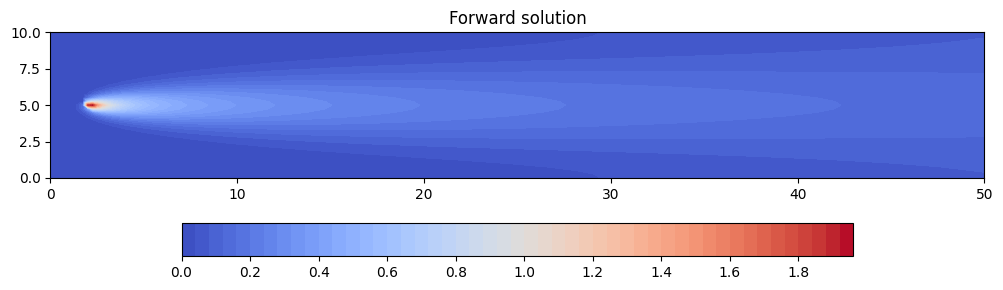

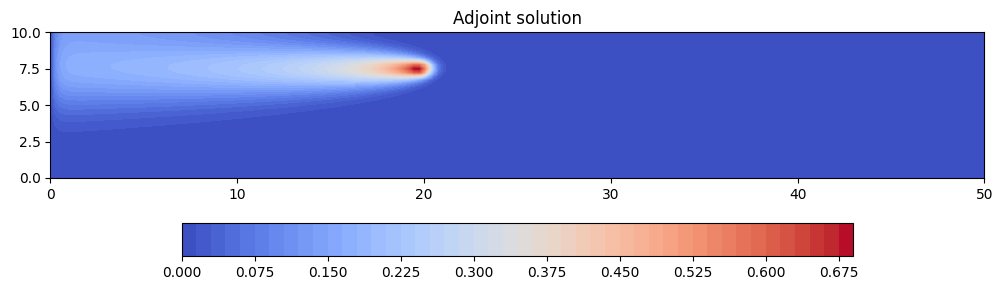

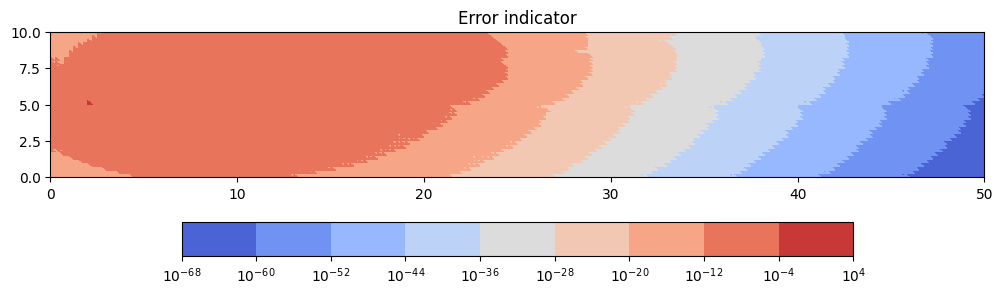

In [35]:
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "h"}
)

sol_c = solutions.c.forward[-1][-1]

import matplotlib.colors as mcolors
from matplotlib import ticker
plot_kwargs = {"levels": 50, "figsize": (10, 3), "cmap": "coolwarm"}
fig, axes, tcs = plot_snapshots(solutions, time_partition, "c", "forward", **plot_kwargs)
fig.colorbar(tcs[0][0], orientation="horizontal", pad=0.2)
axes.set_title("Forward solution")
fig, axes, tcs = plot_snapshots(solutions, time_partition, "c", "adjoint", **plot_kwargs)
fig.colorbar(tcs[0][0], orientation="horizontal", pad=0.2)
axes.set_title("Adjoint solution")
plot_kwargs["norm"] = mcolors.LogNorm()
plot_kwargs["locator"] = ticker.LogLocator()
fig, axes, tcs = plot_indicator_snapshots(indicators, time_partition, **plot_kwargs)
cbar = fig.colorbar(tcs[0][0], orientation="horizontal", pad=0.2)
axes.set_title("Error indicator")

In [45]:
hess = recover_hessian(sol_c)
hmet = hessian_metric(hess)

In [46]:
metric_complexity(hmet)

17.93770989224488

In [9]:
hmet.assign(hmet*1000)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f63d1207130>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 69)

In [10]:
metric_complexity(hmet)

17937.709892245122

In [11]:
def enforce_spd(mesh, metric, restrict_sizes=False, restrict_anisotropy=False):
    """
    Enforce that the metric is symmetric positive-definite.
    :param restrict_sizes: should minimum and maximum metric magnitudes
        be enforced?
    :param restrict_anisotropy: should maximum anisotropy be enforced?
    :return: the :class:`RiemannianMetric`.
    """
    kw = {
        "restrictSizes": restrict_sizes,
        "restrictAnisotropy": restrict_anisotropy,
    }
    plex = mesh.topology_dm
    bsize = metric.dat.cdim
    size = [metric.dat.dataset.total_size * bsize] * 2
    v = PETSc.Vec().createWithArray(metric.dat.data_with_halos, size=size, bsize=bsize, comm=PETSc.COMM_SELF)
    det = plex.metricDeterminantCreate()
    plex.metricEnforceSPD(v, v, det, **kw)
    size = np.shape(metric.dat.data_with_halos)
    metric.dat.data_with_halos[:] = np.reshape(v.array, size)
    v.destroy()
    return metric

def adapt(mesh, metric):
    import firedrake.cython.dmcommon as dmcommon
    """
    Adapt the mesh with respect to the provided metric.
    :return: a new :class:`MeshGeometry`.
    """
    # metric = enforce_spd(mesh, metric, restrict_sizes=True, restrict_anisotropy=True)
    bsize = metric.dat.cdim
    size = [metric.dat.dataset.total_size * bsize] * 2
    v = PETSc.Vec().createWithArray(metric.dat.data_with_halos, size=size, bsize=bsize, comm=PETSc.COMM_SELF)
    newplex = mesh.topology_dm.adaptMetric(v, "Face Sets", "Cell Sets")
    v.destroy()
    return Mesh(newplex, distribution_parameters={"partition": False})

In [42]:
err_ind = indicators[-1][-1]
isomet = isotropic_metric(err_ind)
print(metric_complexity(isomet))
# isomet.assign(isomet*100000000)
# print(metric_complexity(isomet))

9.751103108649707e-05


In [32]:
isomet.dat.data.max()
err_ind.dat.data.max()

0.0008337827471847073

In [49]:
adapted_mesh = adapt(mesh_joe, hmet)
print(adapted_mesh.num_vertices())

5


In [43]:
isomet.dat.data

array([[[8.84404436e-16, 0.00000000e+00],
        [0.00000000e+00, 8.84404436e-16]],

       [[8.42888292e-16, 0.00000000e+00],
        [0.00000000e+00, 8.42888292e-16]],

       [[3.17851879e-16, 0.00000000e+00],
        [0.00000000e+00, 3.17851879e-16]],

       ...,

       [[1.05373368e-57, 0.00000000e+00],
        [0.00000000e+00, 1.05373368e-57]],

       [[8.41215865e-58, 0.00000000e+00],
        [0.00000000e+00, 8.41215865e-58]],

       [[7.43819934e-58, 0.00000000e+00],
        [0.00000000e+00, 7.43819934e-58]]])

In [44]:
err_ind.dat.data

array([8.84404436e-16, 6.13941996e-17, 7.75699970e-18, ...,
       6.79604344e-58, 1.10022332e-57, 7.43819934e-58])

In [47]:
adapted_mesh = adapt(mesh_joe, hmet)

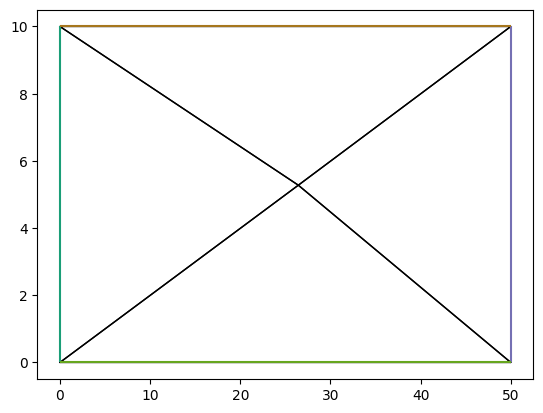

In [48]:
triplot(adapted_mesh)

In [41]:
import numpy as np
from numpy.linalg import eigh


def metric_from_hessian(hessian):  # B is the 2d hessian matrix 2x2
    l_min = 1e-60
    l_max = 1e+60

    B = np.array(hessian)

    # Compute mean diagonal and set values appropriately
    B[0, 1] = 0.5 * (B[0, 1] + B[1, 0])
    B[1, 0] = B[0, 1]

    # Solve eigenvalue problem
    eigen_values, eigen_vectors = eigh(B)

    # Take modulus of eigenvalues
    eigen_values = np.clip(np.abs(eigen_values), l_min, l_max)

    # Build metric from eigendecomposition
    Q = eigen_vectors
    D = np.diag(eigen_values)
    # A += Q @ D @ Q.T

    M = Q @ D @ Q.T
    return M

M = metric_from_hessian(hess.dat.data[1000, :])
# same as hmet.dat.data[1000, :]